In [6]:
#had a lot of issues trying to install the "imputeLCMD" package, so this was how I did it
# if (!requireNamespace("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")

# BiocManager::install(c("impute", "pcaMethods"))

# install.packages("imputeLCMD")

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.r-project.org


Bioconductor version 3.10 (BiocManager 1.30.16), R 3.6.3 (2020-02-29)

Installing package(s) 'impute'

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Old packages: 'DBI', 'DEoptimR', 'DT', 'GGally', 'Hmisc', 'IRdisplay',
  'IRkernel', 'KernSmooth', 'MASS', 'Matrix', 'MatrixModels', 'R6', 'Rcpp',
  'RcppArmadillo', 'SparseM', 'TH.data', 'TTR', 'backports', 'blob', 'boot',
  'brio', 'bslib', 'cachem', 'callr', 'car', 'carData', 'caret', 'class',
  'cli', 'cluster', 'colorspace', 'conquer', 'corrplot', 'cpp11', 'crayon',
  'credentials', 'crosstalk', 'curl', 'data.table', 'dbplyr', 'dendextend',
  'desc', 'devtools', 'diffobj', 'digest', 'diptest', 'dplyr', 'e1071',
  'ellipsis', 'emmeans', 'fansi', 'farver', 'flextable', 'formatR', 'fs',
  'generics', 'gert', 'ggplot2', 'ggsignif', 'gh', 'git2

In [10]:
setwd('/Users/alexis/University of North Carolina at Chapel Hill/Rager, Julia - CEMALB_DataAnalysisPM/Projects/P1003. Ozone Sterols Healthy Asthma/P1003.2. Original Data')
Output = ('/Users/alexis/University of North Carolina at Chapel Hill/Rager, Julia - CEMALB_DataAnalysisPM/Projects/P1003. Ozone Sterols Healthy Asthma/P1003.3. Analyses/P1003.3.2. Ozone Responder Prediction/Output')
cur_date = "012522"

library(imputeLCMD)
library(readxl)
library(tidyverse)
library(gtsummary)
library(caret)
library(e1071)
library(Hmisc)
library(glmnet)

#reading in files
ozone_data = data.frame(read_excel("Ozone_Sterol_Asthma_data_011822.xlsx", sheet = 2)) 
#SHOULD MISSING DATA BE NAS OR ZEROS???
demographics_data = data.frame(read_excel("SubjectInfo_011822.xlsx", sheet = 2))

Loading required package: tmvtnorm

Loading required package: mvtnorm

Loading required package: Matrix

Loading required package: stats4

Loading required package: gmm

Loading required package: sandwich

Loading required package: norm

Loading required package: pcaMethods

Loading required package: Biobase

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following object is masked from ‘package:Matrix’:

    which


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
   

In [11]:
# Need to impute missing data, but values distribution needs to be normalized first
ozone_data = ozone_data %>%
    mutate(Value = ifelse(Value == "NA", NA, as.numeric(Value))) %>%
    #want to normalize within each category, since they're each on different scales (didn't make a diff. though)
    group_by(Category) %>%
    mutate(Value_log10 = log(Value))
head(ozone_data)

Warning message in ifelse(Value == "NA", NA, as.numeric(Value)):
“NAs introduced by coercion”
Warning message in log(Value):
“NaNs produced”
Warning message in log(Value):
“NaNs produced”


Original_Subject_No,Subject_No,Subject_ID,Disease_Status,Sample_Type,Time_Point,Inflammatory_Responder,Lung_Responder,Category,Variable,Value,Value_log10
<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
4,1,AS_1,AS,P,Post,NR,NR,Lung_Function,FEV1,4.39,1.479329
4,1,AS_1,AS,P,Pre,NR,NR,Lung_Function,FEV1,4.60,1.526056
4,1,AS_1,AS,S,Post,NR,NR,Lung_Function,FEV1,4.39,1.479329
4,1,AS_1,AS,S,Pre,NR,NR,Lung_Function,FEV1,NA,NA
7,2,AS_2,AS,P,Post,R,NR,Lung_Function,FEV1,2.96,1.085189
7,2,AS_2,AS,P,Pre,R,NR,Lung_Function,FEV1,3.08,1.124930


In [15]:
impute.QRILC(as.matrix(ozone_data$Value_log10))

ERROR: Error in lm.fit(x, y, offset = offset, singular.ok = singular.ok, ...): NA/NaN/Inf in 'y'


In [2]:
#making response variables factors
ozone_data$Inflammatory_Responder = factor(ozone_data$Inflammatory_Responder)
ozone_data$Lung_Responder = factor(ozone_data$Lung_Responder)

plasma_baseline_ozone_data = full_join(demographics_data, ozone_data) %>%
    #only interested in plasma soluble mediators (cytokines/sterols) at baseline
    filter(Sample_Type == "P" & Time_Point == "Pre") %>%
    filter(Category == "Cytokine" | Category == "Sterol") %>%
    select(-Sample_Type, -Time_Point)
head(plasma_baseline_ozone_data)

Joining, by = c("Original_Subject_No", "Subject_No", "Subject_ID", "Disease_Status")



,Original_Subject_No,Subject_No,Subject_ID,Sex,Race,Ethnicity,Age,BMI,Disease_Status,Visit_Season,Inflammatory_Responder,Lung_Responder,Category,Variable,Value
,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<fct>,<chr>,<chr>,<dbl>
1,4,1,AS_1,M,W,NH,30,23.3,AS,Fa,NR,NR,Cytokine,IFNg,8.0557406
2,4,1,AS_1,M,W,NH,30,23.3,AS,Fa,NR,NR,Cytokine,IL10,0.3476302
3,4,1,AS_1,M,W,NH,30,23.3,AS,Fa,NR,NR,Cytokine,IL12p70,0.4572941
4,4,1,AS_1,M,W,NH,30,23.3,AS,Fa,NR,NR,Cytokine,IL13,7.7955008
5,4,1,AS_1,M,W,NH,30,23.3,AS,Fa,NR,NR,Cytokine,IL1b,0.2763808
6,4,1,AS_1,M,W,NH,30,23.3,AS,Fa,NR,NR,Cytokine,IL2,0.5728830


Seeing if there are statistical differences in predictors stratified by inflammatory or lung status.

In [3]:
#first pivoting wider to make the tbl_summary function work
wider_data = pivot_wider(plasma_baseline_ozone_data %>%
                         #need to remove to not have duplicate rows in wider df
                         select(-Category), names_from = Variable, values_from = Value)
head(wider_data)

Original_Subject_No,Subject_No,Subject_ID,Sex,Race,Ethnicity,Age,BMI,Disease_Status,Visit_Season,⋯,Zym,DHL,7DHD,Des,dHLan,Zyme,Lath,7DHC,8DHC,Chol
<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4,1,AS_1,M,W,NH,30,23.3,AS,Fa,⋯,0.057,0.224,0.091,0.641,0.004,3.014,1.969,1.007,1.262,1110.442
7,2,AS_2,F,W,NH,39,32.7,AS,Sp,⋯,0.046,0.106,0.041,0.286,0.015,2.508,1.287,0.376,0.609,673.328
11,3,AS_3,M,W,NH,23,23.0,AS,Fa,⋯,0.046,0.094,0.033,0.279,0.005,1.549,1.200,0.359,0.776,537.509
13,4,AS_4,M,W,NH,20,21.4,AS,Wi,⋯,0.046,0.085,0.047,0.297,0.016,1.833,1.062,0.265,0.558,482.396
15,5,AS_5,F,B,NH,20,34.5,AS,Su,⋯,0.060,0.116,0.050,0.255,0.020,3.628,1.795,0.473,0.414,586.750
16,6,AS_6,F,W,NH,25,25.2,AS,Su,⋯,0.034,0.077,0.022,0.272,0.006,1.914,0.966,0.434,0.495,639.636


These p values are relatively high, so I'm not expecting the model to predict well. 

In [7]:
#summary statistics df
wider_data %>%
  tbl_summary(by = Inflammatory_Responder, missing = "no", 
  include = c('IFNg','IL10','IL12p70','IL13','IL1b','IL2','IL4','IL6','IL8','TNFa','GMCSF','IL12p40',
              'IL15','IL16','IL17','IL1a','IL5','IL7','TNFb','VEGF','Eotaxin','Eotaxin3','IP10','MCP1','MCP4',
              'MDC','MIP1a','MIP1b','TARC','MPO','25OH_VitD','24OH_Chol','SecoB','25OH_Chol','7Keto_Chol',
              '27OH_Chol','bEP_Chol','Lan','Zym','DHL','7DHD','Des','dHLan','Zyme','Lath','7DHC','8DHC','Chol'), 
              statistic = list(all_continuous() ~ "{mean} ({sd})")) %>%
  add_n() %>% 
  add_p(test = list(all_continuous() ~ "aov")) %>% #adding p value from anova
  as_tibble()

**Characteristic**,**N**,"**NR**, N = 8","**R**, N = 16",**p-value**
<chr>,<chr>,<chr>,<chr>,<chr>
IFNg,24,9.7 (8.9),5.3 (3.1),0.085
IL10,24,0.52 (0.48),0.38 (0.14),0.3
IL12p70,24,0.31 (0.10),0.32 (0.23),0.9
IL13,24,5.97 (1.00),6.84 (3.77),0.5
IL1b,24,NA,NA,0.6
0.14162,NA,7 (88%),15 (94%),NA
0.276380750999999,NA,1 (12%),0 (0%),NA
0.425723693999999,NA,0 (0%),1 (6.2%),NA
IL2,24,0.17 (0.19),0.19 (0.22),0.8


In [5]:
wider_data %>%
  tbl_summary(by = Lung_Responder, missing = "no", 
  include = c('IFNg','IL10','IL12p70','IL13','IL1b','IL2','IL4','IL6','IL8','TNFa','GMCSF','IL12p40',
              'IL15','IL16','IL17','IL1a','IL5','IL7','TNFb','VEGF','Eotaxin','Eotaxin3','IP10','MCP1','MCP4',
              'MDC','MIP1a','MIP1b','TARC','MPO','25OH_VitD','24OH_Chol','SecoB','25OH_Chol','7Keto_Chol',
              '27OH_Chol','bEP_Chol','Lan','Zym','DHL','7DHD','Des','dHLan','Zyme','Lath','7DHC','8DHC','Chol'), 
              statistic = list(all_continuous() ~ "{mean} ({sd})")) %>%
  add_n() %>% 
  add_p(test = list(all_continuous() ~ "aov")) %>% #adding p value from anova
  as_tibble()

ERROR: Error: Error in `include=` argument input. Select from ‘Original_Subject_No’, ‘Subject_No’, ‘Subject_ID’, ‘Sex’, ‘Race’, ‘Ethnicity’, ‘Age’, ‘BMI’, ‘Disease_Status’, ‘Visit_Season’, ‘Inflammatory_Responder’, ‘Lung_Responder’, ‘IFNg’, ‘IL10’, ‘IL12p70’, ‘IL13’, ‘IL1b’, ‘IL2’, ‘IL4’, ‘IL6’, ‘IL8’, ‘TNFa’, ‘GMCSF’, ‘IL12p40’, ‘IL15’, ‘IL16’, ‘IL17’, ‘IL1a’, ‘IL5’, ‘IL7’, ‘TNFb’, ‘VEGF’, ‘Eotaxin’, ‘Eotaxin3’, ‘IP10’, ‘MCP1’, ‘MCP4’, ‘MDC’, ‘MIP1a’, ‘MIP1b’, ‘TARC’, ‘MPO’, ‘25OH_VitD’, ‘24OH_Chol’, ‘SecoB’, ‘25OH_Chol’, ‘7Keto_Chol’, ‘27OH_Chol’, ‘bEP_Chol’, ‘Lan’, ‘Zym’, ‘DHL’, ‘7DHD’, ‘Des’, ‘dHLan’, ‘Zyme’, ‘Lath’, ‘7DHC’, ‘8DHC’, ‘Chol’


# Which demographic information and/or soluble mediators in plasma collected at baseline best predict ozone-responder status in asthmatics and non-asthmatics?

This question will be tackled using 4 supervised machine learning methods assessing both regression and classification...

1. K Nearest Neighbor (KNN)
2. Random Forest
3. Support Vector Machine (SVM)
4. Penalized Logistic Regression

# Random Forest

- an ensemble learning method operating by constructing a multitude of decision trees at training time

In [ ]:
#setting for reproducibility
set.seed(12)
#splitting data into training and testing sets
cancer_data_index = createFolds(cancer_data$TARGET_deathRate, k = 5) #5 fold CV
errors_rf = data.frame()
for (i in 1:length(cancer_data_index)){
  cancer_train = cancer_data[-cancer_data_index[[i]],]
  cancer_test = cancer_data[cancer_data_index[[i]],]
  
  ntree_values = c(50, 250, 500) #number of trees
  p = dim(cancer_data)[2] - 1 #number of variables in dataset
  mtry_values = c(p/2, sqrt(p), p)
  
  #will use ntree and mtry values to determine which combination yields the smallest MSE
  reg_rf_pred_tune = list()
  rf_MSE = list()
  rf_MSE_df = data.frame()
  for (j in 1:length(ntree_values)){
    for (k in 1:length(mtry_values)){
      reg_rf_pred_tune[[k]] = randomForest(TARGET_deathRate~., data = cancer_train, ntree = ntree_values[j], mtry = mtry_values[k])
      rf_MSE[[k]] = data.frame("Tree Number" = ntree_values[j], "Variable Number" = mtry_values[k], 
                               "OOB_MSE" = reg_rf_pred_tune[[k]]$mse[ntree_values[j]])
      rf_MSE_df = rbind(rf_MSE_df, rf_MSE[[k]])
    }
  }
  
  #viewing OOB MSEs
  #print(rf_MSE_df)
  
  #finding the lowest MSE using best number of predictors at split and refitting OG tree
  best_mse <- which(rf_MSE_df$OOB_MSE == min(rf_MSE_df$OOB_MSE))
  reg_rf <- randomForest(TARGET_deathRate~., data = cancer_train, ntree = rf_MSE_df$Tree.Number[best_mse], mtry =
                           rf_MSE_df$Variable.Number[best_mse])
  
  #predicting on test set
  cancer_test$pred_TARGET_deathRate = predict(reg_rf, newdata = cancer_test)
  
  #calculating MSE
  error_values = postResample(cancer_test$pred_TARGET_deathRate, cancer_test$TARGET_deathRate)
  errors_rf = rbind(errors_rf, error_values[[1]]^2)
}
colnames(errors_rf) = c("MSE")
errors_rf = errors_rf %>%
 summarize(`CV Error` = mean(MSE), `Std Error` = sd(MSE))
errors_rf

# Support Vector Machine (SVM)

- predictors by projecting them onto a high dimensional space and uses kernels to make the data more separable (unfortunately makes interpretability of model results more difficult)
- does a better job at handling a large number of predictors than logistic regression, since p < n

In [17]:
#creating df for svm model
svm_data = wider_data[,11:61] %>%
    #need to figure out why these 2 variables keep throwing errors
    select(-Lung_Responder, -Utero, -IL1b) %>%
    #necessary to put it into factor and relevel, so algorithm understands which data is considered baseline
    mutate(Inflammatory_Responder = relevel(factor(ifelse(Inflammatory_Responder == "R", 1, 0)), ref = "0"))
head(svm_data)

Inflammatory_Responder,IFNg,IL10,IL12p70,IL13,IL2,IL4,IL6,IL8,TNFa,⋯,Zym,DHL,7DHD,Des,dHLan,Zyme,Lath,7DHC,8DHC,Chol
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,8.055741,0.3476302,0.4572941,7.795501,0.5728830,0.08653851,4.27020432,624.862506,1.7540356,⋯,0.057,0.224,0.091,0.641,0.004,3.014,1.969,1.007,1.262,1110.442
1,5.456212,0.1802846,0.1292934,2.917929,0.0616800,0.00492000,0.22680099,28.767470,0.8543255,⋯,0.046,0.106,0.041,0.286,0.015,2.508,1.287,0.376,0.609,673.328
0,2.902175,0.4177936,0.2590372,5.633180,0.0616800,0.03890678,0.15432565,4.411786,0.8311165,⋯,0.046,0.094,0.033,0.279,0.005,1.549,1.200,0.359,0.776,537.509
1,3.860980,0.3901140,0.2232882,5.927085,0.1127180,0.03740718,0.47849981,2.909993,1.0738787,⋯,0.046,0.085,0.047,0.297,0.016,1.833,1.062,0.265,0.558,482.396
1,2.652720,0.2658850,0.4454673,4.514058,0.0616800,0.02353853,0.07186388,3.387921,0.5893834,⋯,0.060,0.116,0.050,0.255,0.020,3.628,1.795,0.473,0.414,586.750
0,22.007931,0.4377489,0.1994178,4.951412,0.2333793,0.02990994,1.54397048,3.779592,1.2609131,⋯,0.034,0.077,0.022,0.272,0.006,1.914,0.966,0.434,0.495,639.636


In [18]:
#model errors are calculated to assess the predictive accuracy of the model
svm_classification_model_errors = function(dataset, model, outcome, pred_outcome, gamma_values, cost_values, 
                                           elsilon_values){
  
    #setting seed for reproducibility
    set.seed(12)
    
    #splitting data into training and testing sets
    dataset_index = createFolds(dataset[[outcome]], k = 5) #5 fold CV
    errors = data.frame()
    for (i in 1:length(dataset_index)){
        data_train = dataset[-dataset_index[[i]],]
        data_test = dataset[dataset_index[[i]],]

        #now pruning parameters (based on the training dataset to prevent overfitting)
        svr_tune <- tune(svm, as.formula(paste0(outcome, "~.")), data = data_train, kernel = model, 
                       ranges = list(elsilon = elsilon_values, cost = cost_values, gamma = gamma_values)) 

        #choosing best model
        best_svm <- svr_tune$best.model

        #predicting with tuned parameters 
        data_test[[pred_outcome]] <- predict(best_svm, newdata = data_test, type = "response")

        matrix = confusionMatrix(data = data_test[[pred_outcome]], reference = data_test[[outcome]], 
                                 positive = "1")
        #extracting accuracy, sens, spec, PPV, NPV to take mean and sd later
        error_values = data.frame(t(c(matrix$overall[1], matrix$byClass[1:4])))

        #adding values to df
        errors = rbind(errors, error_values)
  }
  
  #taking averages/sd 
  errors = errors %>%
    summarise(`Accuracy CV Error` = mean(Accuracy), `Sensitivity CV Error` = mean(Sensitivity), 
              `Specificity CV Error` = mean(Specificity), 
              #`PPV CV Error` = mean(Pos.Pred.Value), `NPV CV Error` = mean(Neg.Pred.Value), 
              `Accuracy Std Error` = sd(Accuracy),`Sensitivity Std Error` = sd(Sensitivity), 
              `Specificity Std Error` = sd(Specificity),
              #`PPV CV Error` = sd(Pos.Pred.Value), `NPV CV Error` = sd(Neg.Pred.Value)
             )
  
  return(errors)
}

#calling fn
#linear kernel
svm_linear = svm_classification_model_errors(svm_data, "linear", "Inflammatory_Responder", "pred_Inflammatory_Responder",
                                             0.035, 1:5, seq(0,1,0.2))
#radial
svm_radial = svm_classification_model_errors(svm_data, "radial", "Inflammatory_Responder", "pred_Inflammatory_Responder",
                                             0.035, 1:5, seq(0,1,0.2))
#polynomial
#elison value is fixed at 0.1, but I left it so I didn't have to create a new function
svm_polynomial = svm_classification_model_errors(svm_data, "polynomial", "Inflammatory_Responder", 
                                             "pred_Inflammatory_Responder", 0.035, 1:5, 0.1)

#creating one combined df
final_df = data.frame(rbind(svm_linear, svm_radial, svm_polynomial))
final_df = data.frame(Kernel = c("linear", "radial", "polynomial"), final_df[,1:8])
final_df

Kernel,Accuracy.CV.Error,Sensitivity.CV.Error,Specificity.CV.Error,PPV.CV.Error,NPV.CV.Error,Accuracy.Std.Error,Sensitivity.Std.Error,Specificity.Std.Error
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
linear,0.4800000,0.6166667,0.2,0.30468563,0.4472136,0.29495762,0.3708099,0.2738613
radial,0.6733333,1.0000000,0.0,0.07509254,NA,0.07509254,0.0000000,0.0000000
polynomial,0.6733333,0.8666667,0.3,0.18066236,NA,0.16012148,0.1825742,0.4472136


Might not keep these last 2 methods, since they only can take continuous predictors. 

# K Nearest Neighbor
- seeks to choose the model that minimizes MSE or the difference with the true mean. The model is flexible, which will make it more likely to overfit the training dataset and be less generalizable to other datasets.
- works best for continuous predictors since it groups based on Euclidean distance (a different approach is needed for continuous and dichotomous predictors)

In [6]:
#creating simplifed KNN df
knn_inflammatory_df = wider_data[,11:61] %>%
    #removed Utero since all its data was missing
    select( -Lung_Responder, -Utero, -IL1b)
    #select(-Original_Subject_No, -Subject_No, -Subject_ID, -Lung_Responder, -Utero) 
head(knn_inflammatory_df)

Inflammatory_Responder,IFNg,IL10,IL12p70,IL13,IL2,IL4,IL6,IL8,TNFa,⋯,Zym,DHL,7DHD,Des,dHLan,Zyme,Lath,7DHC,8DHC,Chol
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NR,8.055741,0.3476302,0.4572941,7.795501,0.5728830,0.08653851,4.27020432,624.862506,1.7540356,⋯,0.057,0.224,0.091,0.641,0.004,3.014,1.969,1.007,1.262,1110.442
R,5.456212,0.1802846,0.1292934,2.917929,0.0616800,0.00492000,0.22680099,28.767470,0.8543255,⋯,0.046,0.106,0.041,0.286,0.015,2.508,1.287,0.376,0.609,673.328
NR,2.902175,0.4177936,0.2590372,5.633180,0.0616800,0.03890678,0.15432565,4.411786,0.8311165,⋯,0.046,0.094,0.033,0.279,0.005,1.549,1.200,0.359,0.776,537.509
R,3.860980,0.3901140,0.2232882,5.927085,0.1127180,0.03740718,0.47849981,2.909993,1.0738787,⋯,0.046,0.085,0.047,0.297,0.016,1.833,1.062,0.265,0.558,482.396
R,2.652720,0.2658850,0.4454673,4.514058,0.0616800,0.02353853,0.07186388,3.387921,0.5893834,⋯,0.060,0.116,0.050,0.255,0.020,3.628,1.795,0.473,0.414,586.750
NR,22.007931,0.4377489,0.1994178,4.951412,0.2333793,0.02990994,1.54397048,3.779592,1.2609131,⋯,0.034,0.077,0.022,0.272,0.006,1.914,0.966,0.434,0.495,639.636


k-Nearest Neighbors 

20 samples
47 predictors
 2 classes: 'NR', 'R' 

Pre-processing: centered (47), scaled (47) 
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 20, 20, 20, 20, 20, 20, ... 
Resampling results across tuning parameters:

  k  Accuracy   Kappa       
  5  0.4960000  -0.053670703
  7  0.5524762   0.006853566
  9  0.5642063   0.032846226

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was k = 9.


Warning message:
“predictions failed for Resample15: k=5 Error in dimnames(x) <- dn : 
  length of 'dimnames' [2] not equal to array extent
”
Warning message:
“predictions failed for Resample15: k=7 Error in dimnames(x) <- dn : 
  length of 'dimnames' [2] not equal to array extent
”
Warning message:
“predictions failed for Resample15: k=9 Error in dimnames(x) <- dn : 
  length of 'dimnames' [2] not equal to array extent
”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


k-Nearest Neighbors 

18 samples
47 predictors
 2 classes: 'NR', 'R' 

Pre-processing: centered (47), scaled (47) 
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 18, 18, 18, 18, 18, 18, ... 
Resampling results across tuning parameters:

  k  Accuracy   Kappa      
  5  0.6428737   0.04060373
  7  0.6296627   0.02604299
  9  0.6202381  -0.03567927

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was k = 5.


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


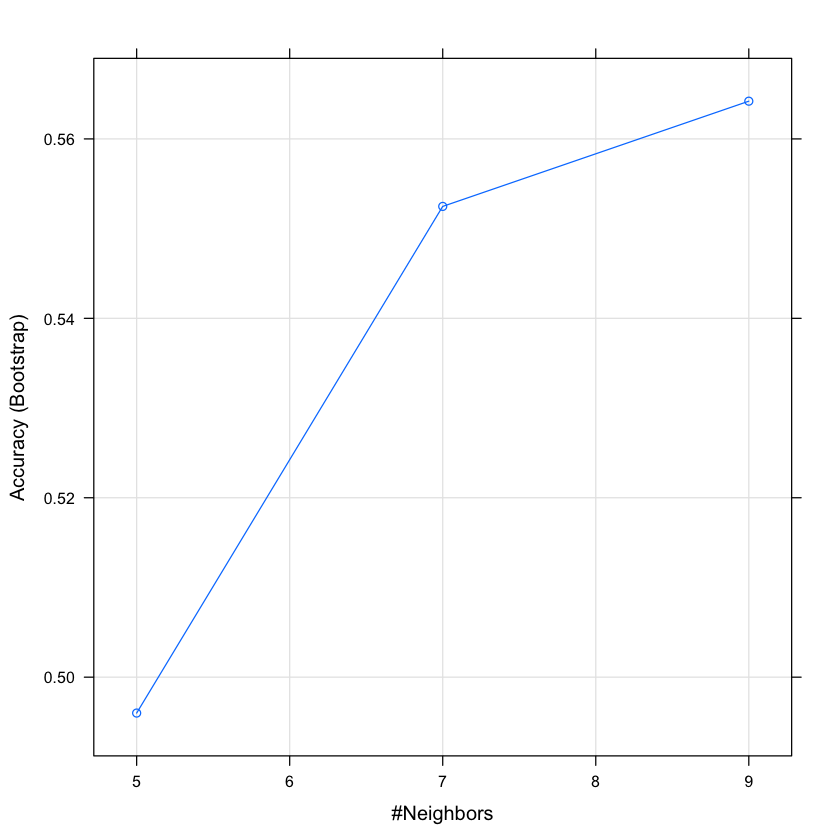

k-Nearest Neighbors 

19 samples
47 predictors
 2 classes: 'NR', 'R' 

Pre-processing: centered (47), scaled (47) 
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 19, 19, 19, 19, 19, 19, ... 
Resampling results across tuning parameters:

  k  Accuracy   Kappa     
  5  0.5448571  0.05432825
  7  0.5314286  0.02469809
  9  0.5610952  0.06826929

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was k = 9.


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


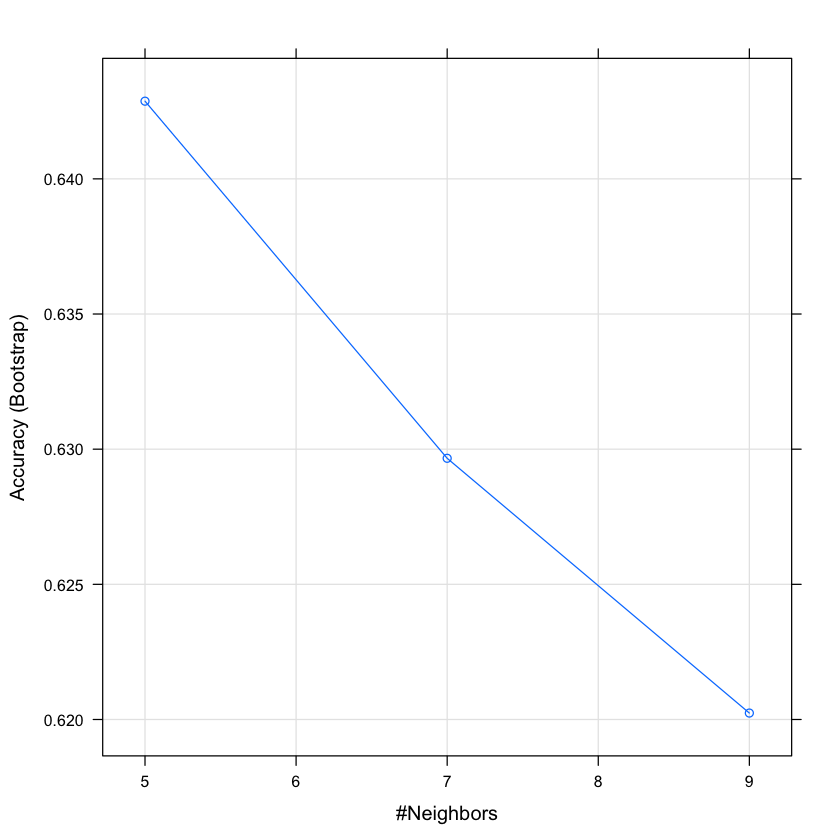

k-Nearest Neighbors 

20 samples
47 predictors
 2 classes: 'NR', 'R' 

Pre-processing: centered (47), scaled (47) 
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 20, 20, 20, 20, 20, 20, ... 
Resampling results across tuning parameters:

  k  Accuracy   Kappa      
  5  0.5850635  -0.03921119
  7  0.6239048   0.02793309
  9  0.6233492   0.05606370

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was k = 7.


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


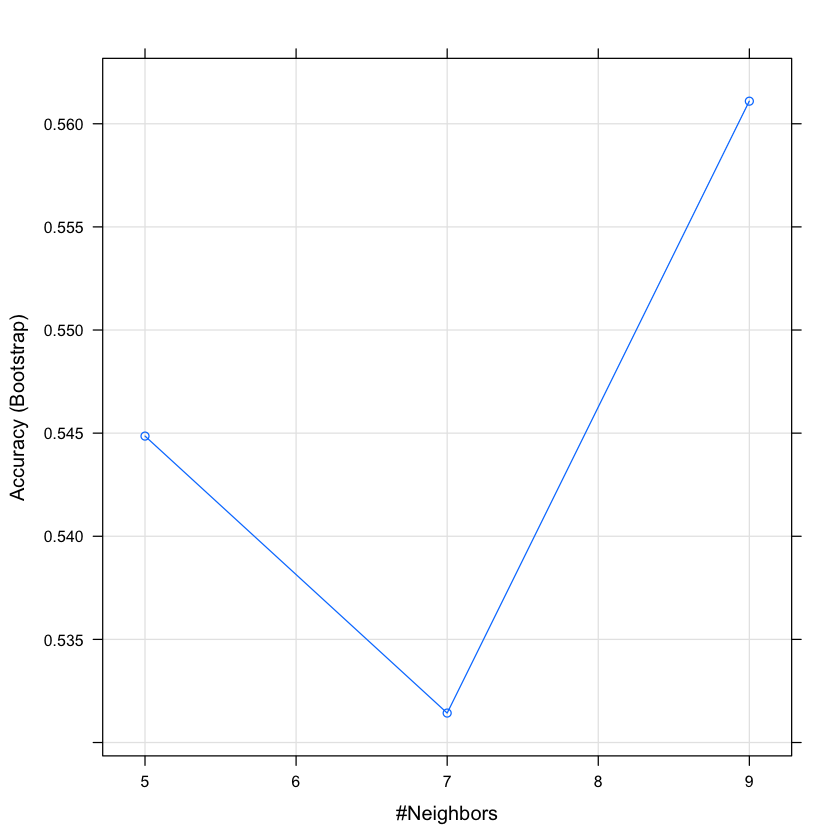

k-Nearest Neighbors 

19 samples
47 predictors
 2 classes: 'NR', 'R' 

Pre-processing: centered (47), scaled (47) 
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 19, 19, 19, 19, 19, 19, ... 
Resampling results across tuning parameters:

  k  Accuracy   Kappa       
  5  0.5830317  -0.039562736
  7  0.6172381  -0.008918258
  9  0.6689048   0.064276696

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was k = 9.


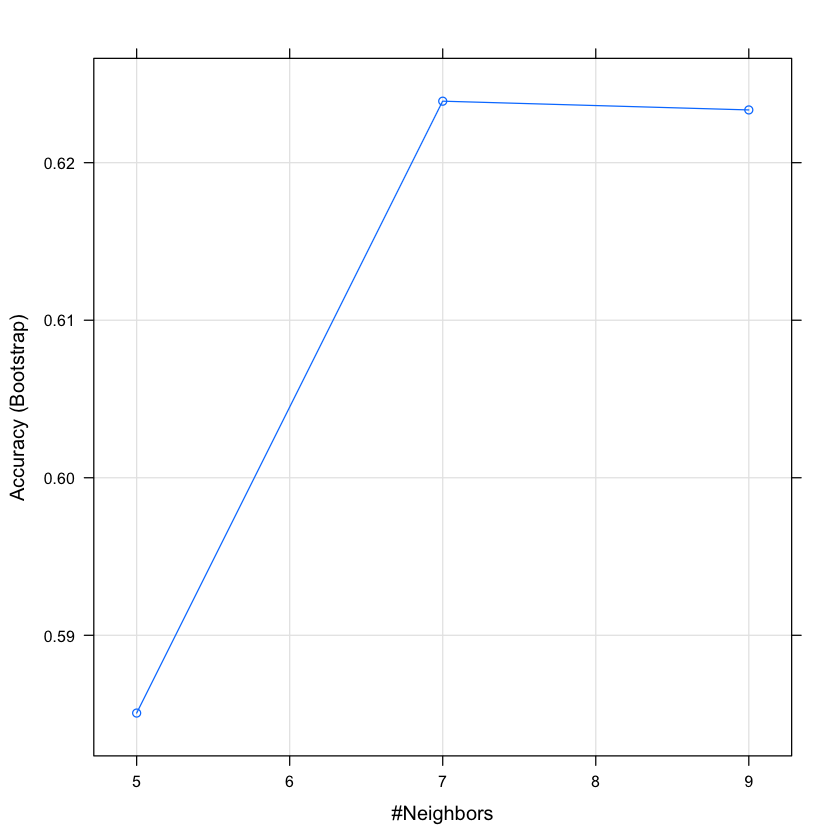

  Method  Accuracy Sensitivity Specificity Pos.Pred.Value Neg.Pred.Value
1    KNN 0.6000000           0   1.0000000            NaN      0.6000000
2    KNN 0.5000000           0   0.6666667              0      0.6666667
3    KNN 0.6000000           0   1.0000000            NaN      0.6000000
4    KNN 0.6666667           0   1.0000000            NaN      0.6666667
5    KNN 0.7500000           0   1.0000000            NaN      0.7500000


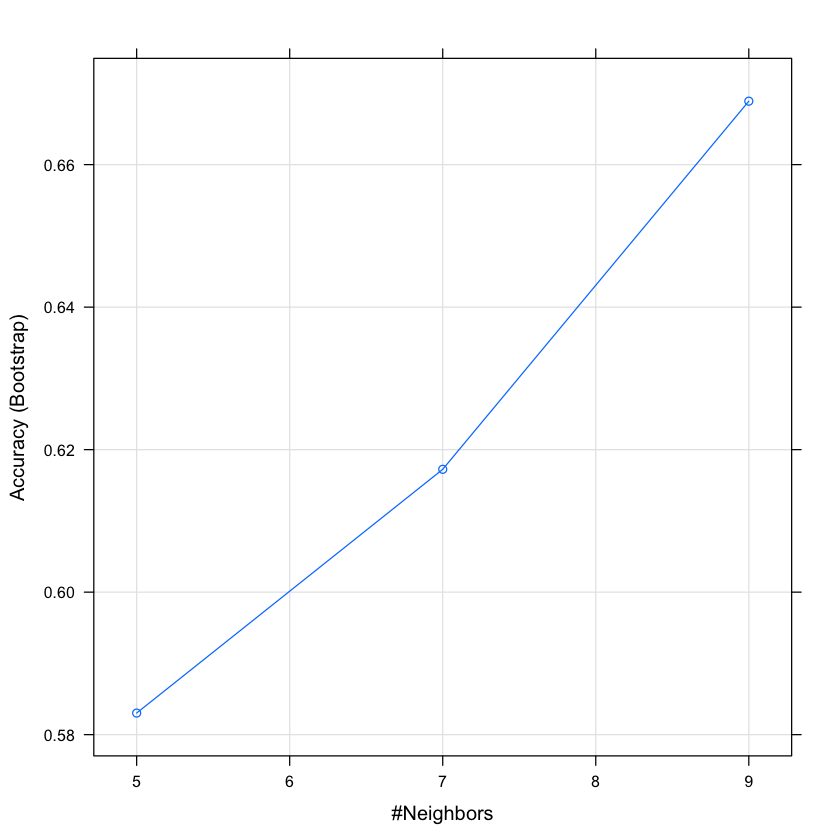

In [21]:
#model errors are calculated to assess the predictive accuracy of the model
# svm_classification_model_errors = function(dataset, outcome, pred_outcome){

#setting seed for reproducibility
set.seed(12)

#splitting data into training and testing sets
knn_inflammatory_df_index = createFolds(knn_inflammatory_df$Inflammatory_Responder, k = 5) #5 fold CV
knn_errors = data.frame()

for (i in 1:length(knn_inflammatory_df_index)){
    model_train = knn_inflammatory_df[-knn_inflammatory_df_index[[i]],]
    model_test = knn_inflammatory_df[knn_inflammatory_df_index[[i]],]

    #training algorithm 
    knn_model = train(Inflammatory_Responder ~ ., data = model_train, method = 'knn', 
                      #trControl = trainControl(method = "cv"), 
                      preProcess = c("center", "scale"))
    print(knn_model)
    
    #plotting 
    print(plot(knn_model))

    #assessing prediction
    knn_pred_Inflammatory_Responder = predict(knn_model, newdata = model_test)
    matrix_knn = confusionMatrix(knn_pred_Inflammatory_Responder, model_test$Inflammatory_Responder)
    #extracting accuracy, sens, spec, PPV, NPV to take mean and sd later
    extracted_values = data.frame(t(c(matrix_knn$overall[1], matrix_knn$byClass[1:4]))) 


    #adding values to df
    knn_errors = data.frame(rbind(cbind(Method = c("KNN"), extracted_values), knn_errors))
}

print(knn_errors)
#   return(errors)
# }

# errors$Method = rep(c("knn", "log", "qda"), times = 5)
# #taking averages/sd by method
# errors = errors %>%
#  group_by(Method) %>%
#  summarize(`CV Error` = mean(Accuracy), `Std Error` = sd(Accuracy))
# errors

# Penalized Logistic Regression

- removes highly correlated variables, before performing logistic regression

In [45]:
# penalized_df = ozone_data %>%
#     #only interested in plasma soluble mediators (cytokines/sterols) at baseline
#     filter(Sample_Type == "P" & Time_Point == "Pre") %>%
#     filter(Category == "Cytokine" | Category == "Sterol" | Variable == "Neutrophils_Change") %>%
#     select(-Sample_Type, -Time_Point, -Inflammatory_Responder, -Lung_Responder) %>%
#     #need to remove to not have duplicate rows in wider df
#     select(-Category) %>%
#     pivot_wider(names_from = Variable, values_from = Value) 

# #removing extraneous/categorical variables
# penalized_df = penalized_df[,5:54]
# head(penalized_df)

penalized_df = knn_inflammatory_df %>%
    mutate(Inflammatory_Responder = ifelse(Inflammatory_Responder == "R", 1, 0))
head(penalized_df)

IFNg,IL10,IL12p70,IL13,IL1b,IL2,IL4,IL6,IL8,TNFa,⋯,DHL,7DHD,Des,dHLan,Zyme,Lath,7DHC,8DHC,Chol,Neutrophils_Change
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
8.055741,0.3476302,0.4572941,7.795501,0.2763808,0.5728830,0.08653851,4.27020432,624.862506,1.7540356,⋯,0.224,0.091,0.641,0.004,3.014,1.969,1.007,1.262,1110.442,8.99
5.456212,0.1802846,0.1292934,2.917929,0.1416200,0.0616800,0.00492000,0.22680099,28.767470,0.8543255,⋯,0.106,0.041,0.286,0.015,2.508,1.287,0.376,0.609,673.328,27.42
2.902175,0.4177936,0.2590372,5.633180,0.1416200,0.0616800,0.03890678,0.15432565,4.411786,0.8311165,⋯,0.094,0.033,0.279,0.005,1.549,1.200,0.359,0.776,537.509,5.17
3.860980,0.3901140,0.2232882,5.927085,0.1416200,0.1127180,0.03740718,0.47849981,2.909993,1.0738787,⋯,0.085,0.047,0.297,0.016,1.833,1.062,0.265,0.558,482.396,24.76
2.652720,0.2658850,0.4454673,4.514058,0.1416200,0.0616800,0.02353853,0.07186388,3.387921,0.5893834,⋯,0.116,0.050,0.255,0.020,3.628,1.795,0.473,0.414,586.750,35.49
22.007931,0.4377489,0.1994178,4.951412,0.1416200,0.2333793,0.02990994,1.54397048,3.779592,1.2609131,⋯,0.077,0.022,0.272,0.006,1.914,0.966,0.434,0.495,639.636,-11.73


In [61]:
#works by removing highly correlated variables prior to running logistric regression
cv_lm_lasso = cv.glmnet(x = data.matrix(penalized_df[,2:48]), 
                        y = unlist(penalized_df$Inflammatory_Responder), alpha = 1)#1 denotes lasso

#fitting model on the whole data set
lm_lasso = glmnet(x = data.matrix(penalized_df[,2:48]), 
                  y = unlist(penalized_df$Inflammatory_Responder), alpha = 1, 
                  lambda = cv_lm_lasso$lambda.min)

#regression estimates
coef(lm_lasso)

Warning message:
“Option grouped=FALSE enforced in cv.glmnet, since < 3 observations per fold”


48 x 1 sparse Matrix of class "dgCMatrix"
                   s0
(Intercept) 0.6666667
IFNg        0.0000000
IL10        .        
IL12p70     .        
IL13        .        
IL2         .        
IL4         .        
IL6         .        
IL8         .        
TNFa        .        
GMCSF       .        
IL12p40     .        
IL15        .        
IL16        .        
IL17        .        
IL1a        .        
IL5         .        
IL7         .        
TNFb        .        
VEGF        .        
Eotaxin     .        
Eotaxin3    .        
IP10        .        
MCP1        .        
MCP4        .        
MDC         .        
MIP1a       .        
MIP1b       .        
TARC        .        
MPO         .        
25OH_VitD   .        
24OH_Chol   .        
SecoB       .        
25OH_Chol   .        
7Keto_Chol  .        
27OH_Chol   .        
bEP_Chol    .        
Lan         .        
Zym         .        
DHL         .        
7DHD        .        
Des         .        
dHLan       